# a run of the full pipeline on our dataset

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["text.usetex"] = True
plt.rcParams["figure.dpi"] = 125

%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("../functions/")

In [5]:
import utils
from analytical import basis_map
from main import predict
from computer_vision import otsu

/home/gvacaliuc/.virtualenvs/ml3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## reading in training data

In [6]:
from utils import DataReader

training_data = DataReader("../data/training/")

ic = training_data.data_ic

In [7]:
metadata, x_train = training_data.get(skip=10)

In [8]:
metadata.head()

,image_id,orig_shape
0,0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e...,"(256, 256)"
1,0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b41...,"(360, 360)"
2,1b2bf5933b0fb82918d278983bee66e9532b53807c3638...,"(256, 256)"
3,1d5f4717e179a03675a5aac3fc1c862fb442ddc3e37392...,"(256, 256)"
4,1f0008060150b5b93084ae2e4dabd160ab80a95ce8071a...,"(360, 360)"


In [9]:
x_train.shape

(67, 128, 128, 3)

In [10]:
y_train = np.stack(training_data.masks)
y_train.shape

(67, 128, 128)

## transforming our basis

In [11]:
from analytical import BasisTransformer

In [12]:
x_train = BasisTransformer().transform(x_train)

## flattening models

In [13]:
from utils import flatten_data

In [18]:
dev_skip = 1

x_dev_flat, y_dev_flat = flatten_data(x_train, y_train, skip=dev_skip)

## model training

In [14]:
from tqdm import tqdm_notebook as tqdm

In [15]:
from sklearn.svm import SVR, SVC
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor

In [16]:
def train_model(estimator, x, y, batch_size = 1000, num_iters = 100):
    
    arange = np.arange(x.shape[0])
    
    for itr in tqdm(range(num_iters)):
        ind = np.random.choice(arange, size = batch_size)
        estimator.partial_fit(x[ind], y[ind])
        
    return estimator

def image_predict(image, model):
    
    num_features = image.shape[-1]
    
    return model.predict(image.reshape((-1, num_features))).reshape(image.shape[:2])

def plot_prediction(model, features, mask):
    
    pred = image_predict(features, model)

    plt.figure()
    plt.subplot(131)
    plt.imshow(features[:, :, :3])
    plt.subplot(132)
    plt.imshow(pred)
    plt.subplot(133)
    plt.imshow(mask)

In [24]:
from models import MiniBatchRegressor

### sgd regressor

In [253]:
sgd_regressor = MiniBatchRegressor(
    regressor=SGDRegressor(penalty='elasticnet', l1_ratio=0.5),
    batch_size=1000,
    num_iters=50000,
    tqdm=tqdm
)
sgd_regressor.fit(x_dev_flat, y_dev_flat)

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

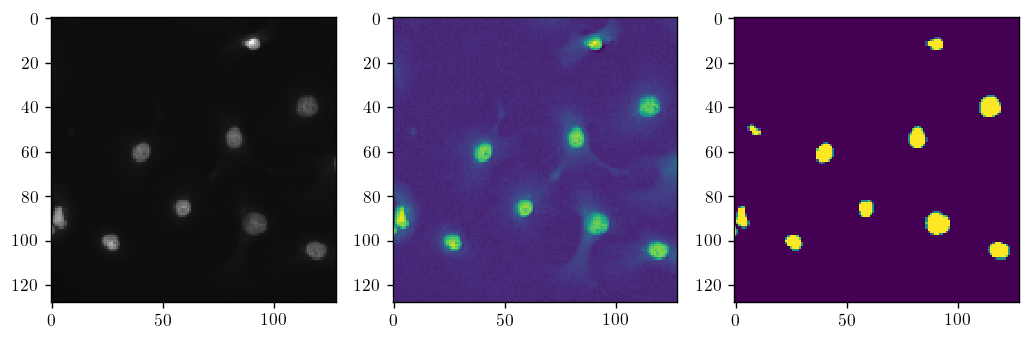

In [254]:
im = x_train[60]
mask = y_train[60]
plot_prediction(sgd_regressor, im, mask)

### pa regressor

In [80]:
pa_regressor = MiniBatchRegressor(
    regressor=PassiveAggressiveRegressor(C = 1.0),
    batch_size=1000,
    num_iters=5000,
    tqdm=tqdm
)
pa_regressor.fit(x_dev_flat, y_dev_flat)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

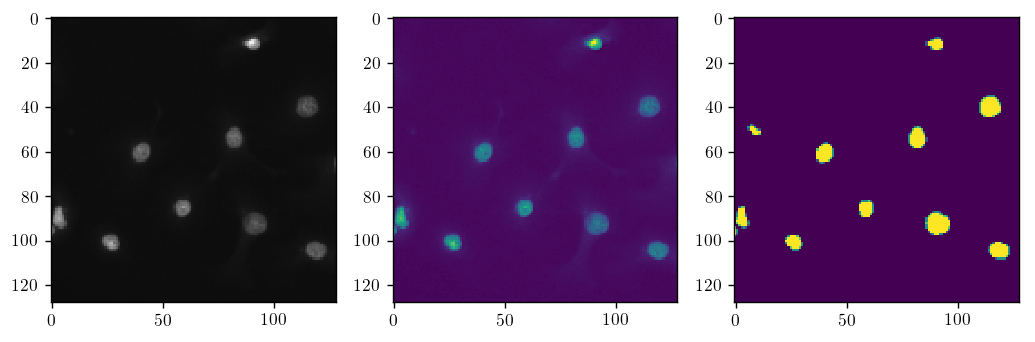

In [82]:
num = 60
im = x_train[num]
mask = y_train[num]
plot_prediction(pa_regressor, im, mask)

### training accuracy

In [93]:
from sklearn.metrics import f1_score
import pandas as pd

In [122]:
def get_results(model, data, labels):
    """
    Data and Labels should be the flattened data / labels.
    """

    results = []
    columns = ["pred_thresh", "mask_thresh", "f1"]

    for pred_thresh in np.arange(0, 1, 0.1):
        for mask_thresh in np.arange(0.5, 0.95, 0.05):
            y_pred = model.predict(data)
            results.append((pred_thresh, mask_thresh, f1_score(labels > mask_thresh, y_pred > pred_thresh)))
            
    return pd.DataFrame(results, columns=columns)

In [255]:
sgd_results = get_results(sgd_regressor, x_dev_flat, y_dev_flat)

In [112]:
pa_results = get_results(pa_regressor, x_dev_flat, y_dev_flat)

In [256]:
sgd_results.groupby("pred_thresh").mean()[["f1"]]

,f1
pred_thresh,
0.0,0.325055
0.1,0.540912
0.2,0.707873
0.3,0.795897
0.4,0.819699
0.5,0.794764
0.6,0.727936
0.7,0.613587
0.8,0.474548


In [116]:
pa_results.groupby("pred_thresh").mean()[["f1"]]

,f1
pred_thresh,
0.0,0.273026
0.1,0.390171
0.2,0.530486
0.3,0.624256
0.4,0.705406
0.5,0.754366
0.6,0.786721
0.7,0.800234
0.8,0.805088


## validation

In [117]:
val_data = DataReader("../data/training/")
val_metadata, x_val = val_data.get(start=1, skip=10)

In [119]:
x_val = BasisTransformer().transform(x_val)
y_val = np.stack(val_data.masks)

In [120]:
x_val_flat, y_val_flat = flatten_data(x_val, y_val)

In [258]:
sgd_results_val = get_results(sgd_regressor, x_val_flat, y_val_flat)

In [123]:
pa_results_val = get_results(pa_regressor, x_val_flat, y_val_flat)

In [259]:
sgd_results_val.groupby("pred_thresh").mean()[["f1"]]

,f1
pred_thresh,
0.0,0.372707
0.1,0.679792
0.2,0.849854
0.3,0.896549
0.4,0.857940
0.5,0.757046
0.6,0.633702
0.7,0.490226
0.8,0.370832


In [125]:
pa_results_val.groupby("pred_thresh").mean()[["f1"]]

,f1
pred_thresh,
0.0,0.317436
0.1,0.490415
0.2,0.650925
0.3,0.765112
0.4,0.826758
0.5,0.863082
0.6,0.877832
0.7,0.881739
0.8,0.875120


# individual masking

Now we've got to get a decent method set up to take our binary predictions and separate the joined mask into several individual nucleus masks.

In [128]:
num = 0
img = x_val[num]
true_mask = y_val[num]
thresh = 0.3
pred_mask = sgd_regressor.predict(img.reshape((-1, 9))).reshape((*img.shape[:2])) > thresh

Text(0.5,1,'true')

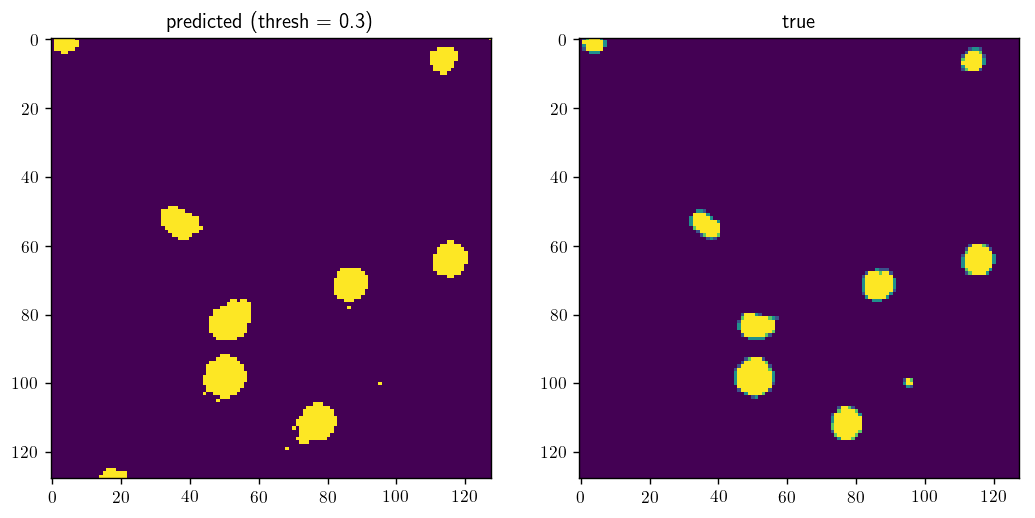

In [132]:
plt.subplot(121)
plt.imshow(pred_mask)
plt.title("predicted (thresh = {})".format(thresh))
plt.subplot(122)
plt.imshow(true_mask)
plt.title("true")

So first of all, we see that our predicted image is somewhat noisy, in the sense that we have some extra little pixels that shouldn't be there.  However, some of the noise is on the same scale as our data (see the true nucleus near (100, 100)).  Likely, we chose a threshold that was too high for some portions
of the image, but too small for others, indicating we need to start doing some soft of local non max supression or local thresholding rather than global thresholding.

Before we get wrapped up in that, let's just assume that any very small predictions such as that are noise that should be taken out.  So let's focus on smoothing up our predicted mask a bit using some morphological methods.  let's take a look at some various methods:

## smoothing our images using morphology

In [133]:
from skimage import morphology

### erosion

Erosion "erodes" away areas of the image that have magnitude.  Interestingly enough, just erosion seems to work quite well!

Text(0.5,1,'true')

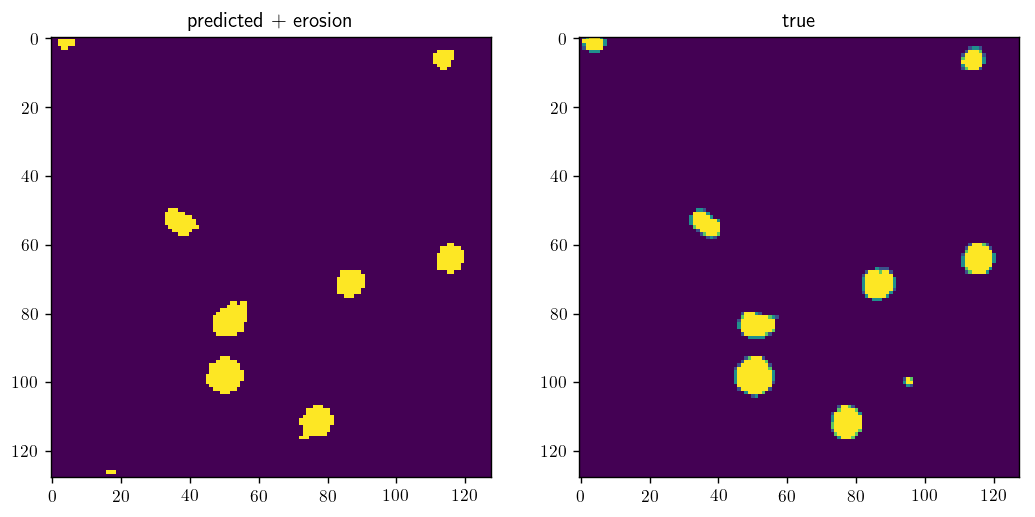

In [143]:
plt.subplot(121)
plt.imshow(morphology.binary_erosion(pred_mask))
plt.title("predicted + erosion".format(thresh))
plt.subplot(122)
plt.imshow(true_mask)
plt.title("true")

### opening

Opening "erodes" then "dilates" an image.  We excluded just dialation because that would simply make our problem worse.  Opening works well for this image since we get rid of that "salt" effect we see.  Unfortunately we also kill a nucleus in that process.

Text(0.5,1,'true')

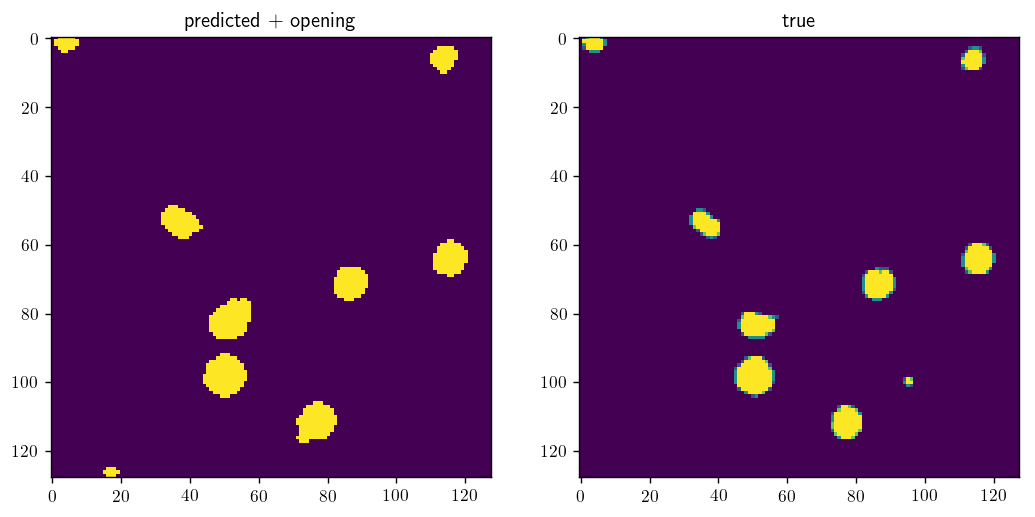

In [146]:
plt.subplot(121)
plt.imshow(morphology.binary_opening(pred_mask))
plt.title("predicted + opening".format(thresh))
plt.subplot(122)
plt.imshow(true_mask)
plt.title("true")

Let's take a look at some more images.

In [147]:
num = 35
img = x_val[num]
true_mask = y_val[num]
thresh = 0.3
pred_mask = sgd_regressor.predict(img.reshape((-1, 9))).reshape((*img.shape[:2])) > thresh

Text(0.5,1,'true')

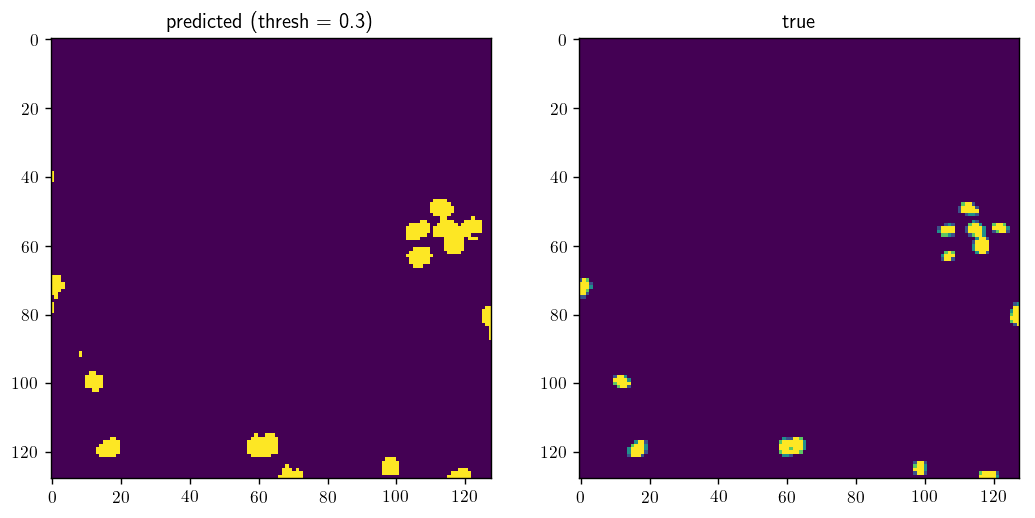

In [148]:
plt.subplot(121)
plt.imshow(pred_mask)
plt.title("predicted (thresh = {})".format(thresh))
plt.subplot(122)
plt.imshow(true_mask)
plt.title("true")

### opening (another image)

Text(0.5,1,'true')

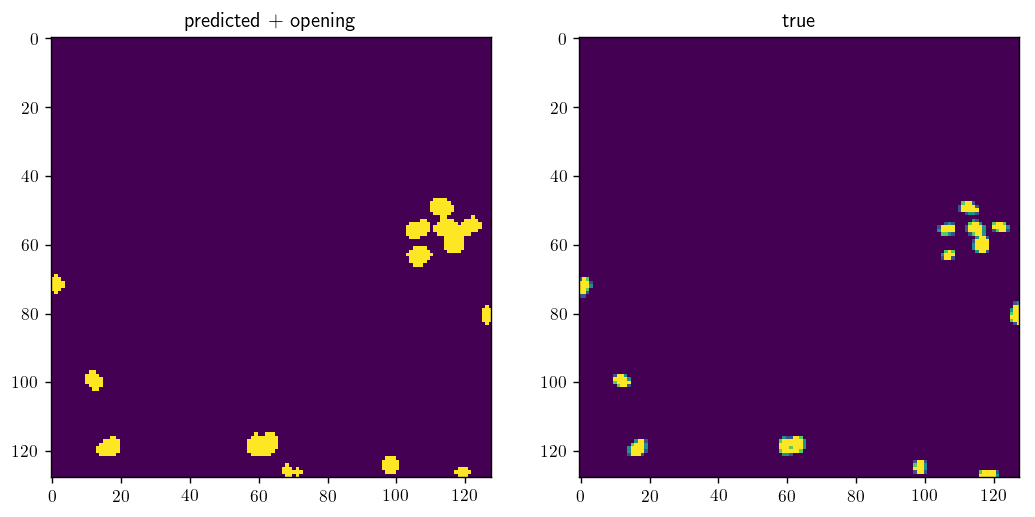

In [150]:
plt.subplot(121)
plt.imshow(morphology.binary_opening(pred_mask))
plt.title("predicted + opening".format(thresh))
plt.subplot(122)
plt.imshow(true_mask)
plt.title("true")

Here one of our issues is that we have one tightly connected cluster of nuclei.  And unfortunately, no morphological operations are going to separate that cluster.  To effectively separate that cluster, we might consider applying weights to our training examples in cases where we have background pixels VERY close to several true pixels.  Then we might be able to better separate those nuclei.  So now this is a task for our labeling algorithm to recognize that we have 4 nuclei there instead of 1.

In [151]:
def morpher(image):
    return morphology.opening(image)

## nucleus segmentation

In [224]:
from components import watershed_cc

Text(0.5,1,'watershed segmentation')

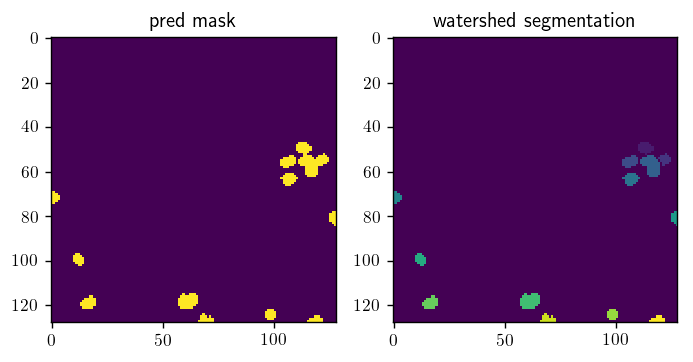

In [231]:
img = morpher(pred_mask)
wcc, wseg = watershed_cc(img, return_mask=True)

plt.subplot(131)
plt.imshow(img)
plt.title("pred mask")
plt.subplot(132)
plt.imshow(wseg)
plt.title("watershed segmentation")

We've chosen to use a simple watershed segmentation algorithm to separate our full image nuclei predictions into individual nucleus labelings.  The way it works is fairly intuitive.  First, you take a distance transform of a given image.  This computes the, in our case euclidean, distance from the nearest "0" value of each pixel.  We then perform non maximum supression on the distance transform to identify the center of each nucleus of interest.  Finally, we perform the watershed segmentation using those centers which, intuitively, fills up the basin based on the information in the distance transform and using the centers to separate components.

## implementation of competition metric

## resize images to original size

Of course, in our submission we must submit our predictions for the nuclei based on the original size of the images, not in our downsampled space.

## prediction and submission on the test set

In [354]:
test_data = DataReader("../data/testing/", train=False)
test_metadata, x_test = test_data.get()

In [355]:
x_test_transformed = BasisTransformer().transform(x_test)

In [356]:
y_test_pred = sgd_regressor.predict_images(x_test_transformed)
y_test_thresholded = y_test_pred > 0.3

In [357]:
from components import NucleiSegmenter

In [358]:
segmenter = NucleiSegmenter()
y_test_pred_nuclei = segmenter.fit_transform(y_test_thresholded)

In [359]:
from submission import RLEncoder

In [360]:
encoder = RLEncoder()
submission_df = encoder.fit_transform(test_metadata, y_test_pred_nuclei)

In [361]:
submission_df.to_csv("../submissions/20180318-01.csv", index=False)